In [1]:
import os
import pandas as pd
import pickle
from matplotlib import pyplot as plt
import numpy as np
from ribbn_scripts.processing.get_offset import get_offset
from ribbn_scripts.processing.phase_estimate import multidist_multifreq_phase_estimation
from ribbn_scripts.processing.localization import estimate_dph_df,direct_distance_estimate,estimate_k,unwrap_phases
from ribbn_scripts.ref_functions.spec_functions import read_network_analyzer_file, get_theta, get_amplitude, s2z
import pickle

In [2]:
# loading notes csv
notes = pd.read_csv('notes.csv')

In [3]:
notes

,Sno,Wall Dist,T2T Dist
0,0,17.5,112.2
1,1,17.5,112.2
2,2,17.5,112.2
3,3,17.5,112.2
4,4,17.5,112.2
...,...,...,...
65,65,147.5,112.2
66,66,147.5,112.2
67,67,147.5,112.2
68,68,147.5,112.2


In [4]:
df_all=None
file_names = sorted([f for f in os.listdir("dataframes") if f[0] != '.'], key=lambda x: int(x.split('.')[0]))
for file_name in file_names:
    dist_idx=int(file_name.split(".")[0])
    T2Tdist=float(notes[notes['Sno']==dist_idx]['T2T Dist'].iloc[0])
    wallDist=float(notes[notes['Sno']==dist_idx]['Wall Dist'].iloc[0])
    with open(f'dataframes/{file_name}', "rb") as f:
        print(file_name)
        _df = pickle.load(f)
        # Add new columns to _df for all rows
        _df['Run Exp Num'] = dist_idx
        _df['dist'] = T2Tdist/100
        _df['wall dist'] = wallDist/100
        if df_all is None:
            df_all=_df
        else:
            df_all = pd.concat([df_all, _df], ignore_index=True)

df_all

0.df
1.df
2.df
3.df
4.df
5.df
6.df
7.df
8.df
9.df
10.df
11.df
12.df
13.df
14.df
15.df
16.df
17.df
18.df
19.df
20.df
21.df
22.df
23.df
24.df
25.df
26.df
27.df
28.df
29.df
30.df
31.df
32.df
33.df
34.df
35.df
36.df
37.df
38.df
39.df
40.df
41.df
42.df
43.df
44.df
45.df
46.df
47.df
48.df
49.df
50.df
51.df
52.df
53.df
54.df
55.df
56.df
57.df
58.df
59.df
60.df
61.df
62.df
63.df
64.df
65.df
66.df
67.df
68.df
69.df


,Rx,Tx,MPP Start Time (s),MPP Stop Time (s),Voltages (mV),Frequency (MHz),Run Exp Num,NumMPPs,dist,wall dist
0,Tag1,Tag2,1.758137e+09,1.758137e+09,"[38.03, 38.34, 37.96, 37.96, 38.34, 37.8, 38.5...",915,0,5,1.122,0.175
1,Tag2,Tag1,1.758137e+09,1.758137e+09,"[33.07, 37.35, 37.58, 36.89, 37.12, 38.03, 37....",915,0,5,1.122,0.175
2,Tag1,Tag2,1.758137e+09,1.758137e+09,"[35.67, 33.68, 33.76, 33.76, 33.38, 33.53, 33....",915,1,5,1.122,0.175
3,Tag2,Tag1,1.758137e+09,1.758137e+09,"[120.28, 124.32, 125.93, 124.93, 124.4, 124.48...",915,1,5,1.122,0.175
4,Tag1,Tag2,1.758137e+09,1.758137e+09,"[277.75, 280.96, 281.11, 281.41, 281.19, 281.1...",915,2,5,1.122,0.175
...,...,...,...,...,...,...,...,...,...,...
135,Tag2,Tag1,1.758231e+09,1.758231e+09,"[60.31, 57.72, 57.41, 57.18, 57.79, 57.87, 57....",915,67,5,1.122,1.475
136,Tag1,Tag2,1.758231e+09,1.758231e+09,"[108.15, 111.05, 110.67, 111.35, 111.05, 111.6...",915,68,5,1.122,1.475
137,Tag2,Tag1,1.758231e+09,1.758231e+09,"[64.05, 72.82, 72.29, 72.9, 73.21, 73.36, 72.3...",915,68,5,1.122,1.475
138,Tag1,Tag2,1.758231e+09,1.758231e+09,"[86.4, 84.8, 85.18, 85.11, 85.34, 85.26, 85.41...",915,69,5,1.122,1.475


In [5]:
time_per_phase = 10/1000  # s
num_phases=6
num_mpps=df_all.iloc[0]['NumMPPs']
sampling_rate=1000
plotting=False
ver_lines = [0] + [ (time_per_phase-time_per_phase*0.01) * sampling_rate * (i + 1) for i in range(num_phases*num_mpps)]

processedDF=pd.DataFrame(columns=["Rx","Tx", "Voltages (mV)", "Phase1","Phase3","Phase4","Phase6","Phase7","Phase8",
                                "Frequency (MHz)", "Run Exp Num", "NumMPPs"])
processedDF_aggregated=pd.DataFrame(columns=["Rx","Tx","phase", "median", "std","freq", "dist", 'delta', "Experiment Number", "Unique Exp Number"])

if plotting:
    plt.figure(figsize=(15,20))

unique_exp_no=0
phase_order=[1,3,4,6,7,8]

for df_idx in range(len(df_all)):

    voltages=df_all.iloc[df_idx]['Voltages (mV)']
    phase_medians={
        1:[],
        3:[],
        4:[],
        6:[],
        7:[],
        8:[],
    }
    for idx,v in enumerate(ver_lines):
        if idx<len(ver_lines)-1:
            phase_medians[phase_order[int(idx%num_phases)]].append(np.median(voltages[int(ver_lines[idx]):int(ver_lines[idx+1])]))   
        if plotting:
            plt.subplot(len(df_all)//3+1, 3, df_idx+1)
            if idx%num_phases==0:
                plt.axvline(x=v, color='b', linestyle='-')
            else:
                plt.axvline(x=v, color='r', linestyle='--')
    entry={
        "Rx": df_all.iloc[df_idx]["Rx"],
        "Tx":df_all.iloc[df_idx]["Tx"],
        "Voltages (mV)":df_all.iloc[df_idx]["Voltages (mV)"],
        "Phase1":phase_medians[1],
        "Phase3":phase_medians[3],
        "Phase4":phase_medians[4],
        "Phase6":phase_medians[6],
        "Phase7":phase_medians[7],
        "Phase8":phase_medians[8],
        "Frequency (MHz)":df_all.iloc[df_idx]["Frequency (MHz)"],
        "Run Exp Num":df_all.iloc[df_idx]["Run Exp Num"],
        "Dist (m)":df_all.iloc[df_idx]["dist"],
        "Wall Dist (m)":df_all.iloc[df_idx]["wall dist"],
        "NumMPPs":df_all.iloc[df_idx]["NumMPPs"],
    }
    for phase in phase_order:
        entry_aggregated={
            "Rx":df_all.iloc[df_idx]["Rx"],
            "Tx":df_all.iloc[df_idx]["Tx"],
            "phase": str(phase),
            "median": np.mean(phase_medians[phase]), # mean of medians
            "std": np.std(phase_medians[phase]),
            "freq": df_all.iloc[df_idx]["Frequency (MHz)"]*1e6,
            "dist":df_all.iloc[df_idx]["dist"],
            "wall dist":df_all.iloc[df_idx]["wall dist"],
            'delta': max(phase_medians[phase])-min(phase_medians[phase]),
            "Experiment Number":df_all.iloc[df_idx]["Run Exp Num"],
            "Unique Exp Number":unique_exp_no,
            "allVoltages": phase_medians[phase]
        }
        processedDF_aggregated=pd.concat([processedDF_aggregated, pd.DataFrame([entry_aggregated])], ignore_index=True)
    unique_exp_no+=1
    
    # Identify and print bad MPPs
    bad=False
    for k in phase_medians.keys():
        assert(len(phase_medians[k])==num_mpps)
        if np.std(phase_medians[k])>1:
            d=df_all.iloc[df_idx]["Laser dist"]
            print(f"<== Bad data found at {df_idx} df_idx at phase {k} at T2T dist {d}.", end="\t")
            print(f"Num vals: {len(phase_medians[k])}, mean: {np.mean(phase_medians[k])}, stdev: {np.std(phase_medians[k])} ==>")
    
    processedDF=pd.concat([processedDF,pd.DataFrame([entry])],ignore_index=True)
    if plotting:
        plt.plot(voltages,'.')
        plt.title(df_idx)
        plt.tight_layout()
        
if plotting:
    plt.show()
    

    

/var/folders/hm/7p8fzz2x2y10pbydpxcs7vw00000gn/T/ipykernel_34682/4270132101.py:69: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  processedDF_aggregated=pd.concat([processedDF_aggregated, pd.DataFrame([entry_aggregated])], ignore_index=True)


In [6]:
with open("processedDF.pkl", 'wb') as f:
    pickle.dump(processedDF,f)
processedDF

,Rx,Tx,Voltages (mV),Phase1,Phase3,Phase4,Phase6,Phase7,Phase8,Frequency (MHz),Run Exp Num,NumMPPs,Dist (m),Wall Dist (m)
0,Tag1,Tag2,"[38.03, 38.34, 37.96, 37.96, 38.34, 37.8, 38.5...","[38.03, 38.03, 37.96, 37.765, 38.11]","[38.64, 38.68, 38.76, 38.644999999999996, 38.875]","[39.6, 39.519999999999996, 39.635000000000005,...","[37.995000000000005, 37.8, 37.65, 37.995000000...","[37.5, 37.58, 37.69, 37.73, 37.58]","[37.655, 37.765, 37.58, 37.915, 38.03]",915,0,5,1.122,0.175
1,Tag2,Tag1,"[33.07, 37.35, 37.58, 36.89, 37.12, 38.03, 37....","[37.35, 37.27, 37.0, 37.12, 37.269999999999996]","[35.29, 35.405, 34.75, 35.44, 34.64]","[33.685, 33.495, 32.465, 32.85, 32.58]","[32.345, 32.16, 32.155, 32.69, 32.5]","[32.19499999999999, 33.0, 33.11, 32.575, 32.615]","[33.15, 33.265, 33.8, 32.845, 33.34]",915,0,5,1.122,0.175
2,Tag1,Tag2,"[35.67, 33.68, 33.76, 33.76, 33.38, 33.53, 33....","[33.53, 33.46, 33.379999999999995, 33.76, 33.3...","[34.675, 34.715, 34.795, 34.45, 34.75]","[38.26, 38.19, 38.19, 37.8, 37.955]","[35.095, 34.635000000000005, 34.64, 34.52, 34....","[33.95, 33.84, 33.605000000000004, 33.72, 33.6...","[33.53, 33.379999999999995, 33.42, 33.345, 33....",915,1,5,1.122,0.175
3,Tag2,Tag1,"[120.28, 124.32, 125.93, 124.93, 124.4, 124.48...","[124.63, 125.01, 124.86, 124.74000000000001, 1...","[124.285, 124.7, 124.16999999999999, 123.71, 1...","[117.57, 117.41499999999999, 117.265, 117.99, ...","[117.685, 117.57, 117.875, 117.535, 117.765]","[118.41, 118.52, 118.37, 118.565, 118.56]","[120.125, 119.82, 119.705, 119.75, 119.67]",915,1,5,1.122,0.175
4,Tag1,Tag2,"[277.75, 280.96, 281.11, 281.41, 281.19, 281.1...","[281.11, 281.375, 281.3, 281.29999999999995, 2...","[281.57, 281.375, 281.375, 281.605, 281.87]","[274.4, 274.435, 274.36, 274.4, 275.1950000000...","[275.91999999999996, 275.92, 276.0, 276.265, 2...","[277.56, 277.6, 277.68, 278.4, 278.02]","[280.5, 280.42, 280.155, 280.805, 280.615]",915,2,5,1.122,0.175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,Tag2,Tag1,"[60.31, 57.72, 57.41, 57.18, 57.79, 57.87, 57....","[57.72, 57.525, 57.565, 57.870000000000005, 57...","[56.805, 57.03, 56.84, 56.724999999999994, 56.99]","[60.425, 60.39, 60.425, 60.23, 60.345]","[60.004999999999995, 59.93, 59.89, 59.66, 59.89]","[59.47, 59.55, 59.36, 59.47, 59.24]","[58.635000000000005, 58.67, 58.595, 58.67, 58....",915,67,5,1.122,1.475
136,Tag1,Tag2,"[108.15, 111.05, 110.67, 111.35, 111.05, 111.6...","[111.05, 110.85499999999999, 111.2400000000000...","[110.245, 110.21, 109.905, 110.17, 110.015]","[105.745, 105.555, 105.94, 105.78, 105.9]","[108.64500000000001, 108.53, 109.065, 108.755,...","[109.75, 109.75, 109.78999999999999, 109.75, 1...","[110.55000000000001, 110.82, 110.59, 110.85499...",915,68,5,1.122,1.475
137,Tag2,Tag1,"[64.05, 72.82, 72.29, 72.9, 73.21, 73.36, 72.3...","[72.82, 72.71000000000001, 72.745, 72.59, 72.445]","[67.6, 67.41, 67.675, 67.25, 67.485]","[63.935, 63.480000000000004, 63.74, 63.74, 63.44]","[62.07, 62.07, 62.22, 62.07, 61.834999999999994]","[61.76, 62.14, 62.03, 62.065, 62.254999999999995]","[62.485, 62.29, 62.485, 62.485, 62.45]",915,68,5,1.122,1.475
138,Tag1,Tag2,"[86.4, 84.8, 85.18, 85.11, 85.34, 85.26, 85.41...","[85.26, 84.99000000000001, 84.875, 85.11, 85.34]","[85.87, 85.985, 86.06, 86.215, 86.36500000000001]","[86.595, 86.935, 86.86, 86.71, 86.86]","[84.65, 84.22999999999999, 84.38, 84.305, 84.27]","[84.19, 84.19, 84.57, 84.38, 84.69]","[84.65, 84.65, 84.61, 84.46000000000001, 84.99...",915,69,5,1.122,1.475


In [7]:
with open("processedDF_aggregated.pkl", 'wb') as f:
    pickle.dump(processedDF_aggregated,f)
processedDF_aggregated

,Rx,Tx,phase,median,std,freq,dist,delta,Experiment Number,Unique Exp Number,wall dist,allVoltages
0,Tag1,Tag2,1,37.979,0.117064,915000000.0,1.122,0.345,0,0,0.175,"[38.03, 38.03, 37.96, 37.765, 38.11]"
1,Tag1,Tag2,3,38.720,0.088600,915000000.0,1.122,0.235,0,0,0.175,"[38.64, 38.68, 38.76, 38.644999999999996, 38.875]"
2,Tag1,Tag2,4,39.673,0.119231,915000000.0,1.122,0.340,0,0,0.175,"[39.6, 39.519999999999996, 39.635000000000005,..."
3,Tag1,Tag2,6,37.826,0.146472,915000000.0,1.122,0.345,0,0,0.175,"[37.995000000000005, 37.8, 37.65, 37.995000000..."
4,Tag1,Tag2,7,37.616,0.083090,915000000.0,1.122,0.230,0,0,0.175,"[37.5, 37.58, 37.69, 37.73, 37.58]"
...,...,...,...,...,...,...,...,...,...,...,...,...
835,Tag2,Tag1,3,31.862,0.137390,915000000.0,1.122,0.420,69,139,1.475,"[32.045, 31.93, 31.855, 31.625, 31.855]"
836,Tag2,Tag1,4,27.518,0.110027,915000000.0,1.122,0.305,69,139,1.475,"[27.425, 27.695, 27.5, 27.58, 27.39]"
837,Tag2,Tag1,6,28.956,0.098560,915000000.0,1.122,0.265,69,139,1.475,"[28.805, 28.88, 28.994999999999997, 29.03, 29.07]"
838,Tag2,Tag1,7,29.802,0.074068,915000000.0,1.122,0.190,69,139,1.475,"[29.755000000000003, 29.87, 29.72, 29.755, 29.91]"


In [8]:
lambda_ = 3e8/915e6
th_phi = 2*np.pi*(112.2/100)/lambda_
th_phi = th_phi % (np.pi)

In [9]:
# freq_range=np.array(range(775,1000,10))*1e6
freq_range=np.array([915])*1e6
all_freqs, all_freqs_unwrapped, all_freqs_theoretical, all_freqs_theoretical_unwrapped, all_errors, \
    selected_experiments_all = multidist_multifreq_phase_estimation(freq_range,processedDF_aggregated,correction_factor=0,plot=False)

with open("no_correction_all_errs.pkl",'wb') as f:
    pickle.dump(all_errors,f)
    
with open("no_correction_all_phases.pkl",'wb') as f:
    pickle.dump(all_freqs,f)

with open("no_correction_all_phases_unwrapped.pkl",'wb') as f:
    pickle.dump(all_freqs_unwrapped,f)    

with open("theoretical_phase.pkl",'wb') as f:
    pickle.dump(all_freqs_theoretical,f)    

In [10]:
x=[]
for i in processedDF_aggregated["wall dist"].unique():
    x+=[i]*5

Text(0, 0.5, 'Phase (deg)')

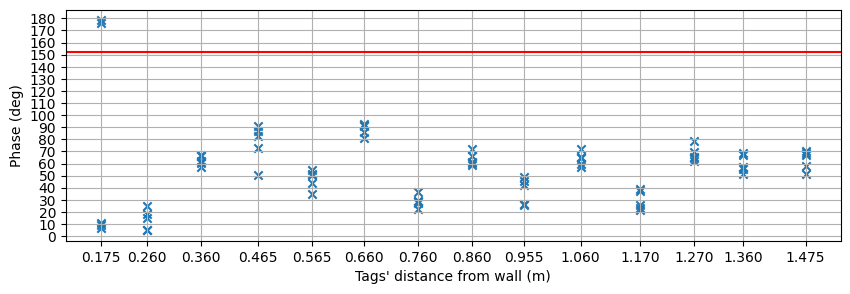

In [11]:
plt.figure(figsize=(10,3))
plt.axhline(y=np.rad2deg(th_phi), color='r', linestyle='-', label="expected phase")
plt.scatter(x, np.rad2deg(all_freqs[915e6][1.122]), marker='x')
plt.xticks(processedDF_aggregated["wall dist"].unique())
plt.yticks(np.arange(0,181,10))
plt.grid()

plt.xlabel("Tags' distance from wall (m)")
plt.ylabel("Phase (deg)")


### With offset correction using the ground truth.

In [12]:
# correction_offsets={}
# all_errors=None


# all_freqs, all_freqs_unwrapped, all_freqs_theoretical, all_freqs_theoretical_unwrapped, _,_=\
#     multidist_multifreq_phase_estimation(freq_range,processedDF_aggregated,correction_factor=0,plot=False)


# for freq in freq_range:
#     offset,best_error,errors=get_offset(all_freqs[freq],freq)
#     # print(f"Freq {freq//1e6};\t Mean:{np.mean(errors)};\t Median:{np.median(errors)};\t Std:{np.std(errors)}")
#     # if all_errors is None:
#     #     all_errors=errors
#     # else:
#     #     all_errors=np.concat((all_errors,errors))
#     correction_offsets[freq]=offset



# all_freqs, all_freqs_unwrapped, all_freqs_theoretical, all_freqs_theoretical_unwrapped, all_errors,_=\
#     multidist_multifreq_phase_estimation(freq_range,processedDF_aggregated,correction_factor=correction_offsets,plot=True)


# with open("gt_correction_all_errs.pkl",'wb') as f:
#     pickle.dump(all_errors,f)
    
# with open("gt_correction_all_phases.pkl",'wb') as f:
#     pickle.dump(all_freqs,f)

# with open("gt_correction_all_phases_unwrapped.pkl",'wb') as f:
#     pickle.dump(all_freqs_unwrapped,f)    

### With correction offsets from pretrained

In [13]:
correction_offsets=pickle.load(open("/Users/manavjeet/git/T2TExperiments/DistExperiments/correction_offsets.pkl",'rb'))

all_freqs, all_freqs_unwrapped, all_freqs_theoretical, all_freqs_theoretical_unwrapped, all_errors,_=\
    multidist_multifreq_phase_estimation(freq_range,processedDF_aggregated,correction_factor=correction_offsets,plot=False)


with open("pretrained_correction_all_errs.pkl",'wb') as f:
    pickle.dump(all_errors,f)
    
with open("pretrained_correction_all_phases.pkl",'wb') as f:
    pickle.dump(all_freqs,f)

with open("pretrained_correction_all_phases_unwrapped.pkl",'wb') as f:
    pickle.dump(all_freqs_unwrapped,f)

Text(0, 0.5, 'Phase (deg)')

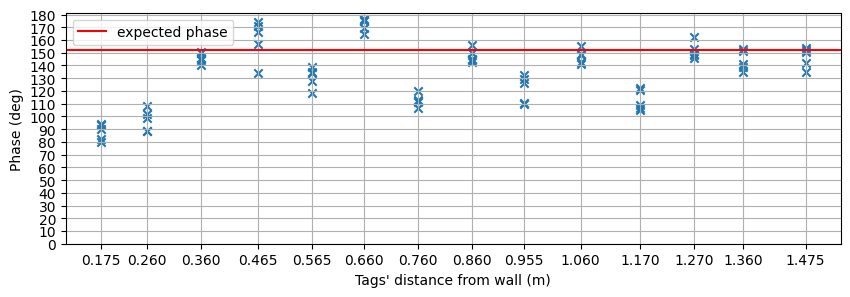

In [14]:


plt.figure(figsize=(10,3))
plt.axhline(y=np.rad2deg(th_phi), color='r', linestyle='-', label="expected phase")
plt.scatter(x, np.rad2deg(all_freqs[915e6][1.122]), marker='x')
plt.xticks(processedDF_aggregated["wall dist"].unique())
plt.yticks(np.arange(0,181,10))
plt.legend()
plt.grid()

plt.xlabel("Tags' distance from wall (m)")
plt.ylabel("Phase (deg)")


In [15]:
th_phi

2.6521325181605064